<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/TF_ObjDet_SSD_MobNet/Car_BBOX_Det_SSD_Mob_Net_TF_ObjDetAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car BBOX Detection - TensorFlow Object Detection API

* Dataset - [Stanford Cars Dataset](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder)
* This notebook used the TensorFlow object detection API to perform classification and BBOX detection on the Stanford Car Dataset.

# Complete setups and other preliminaries

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Complete all installations and copy required files


In [ ]:
%%capture

# Clone TF models repository from GitHUb
!git clone https://github.com/tensorflow/models

In [ ]:
%%bash

# Setup Object Detection API
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --quiet .

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
%%capture

# Create Dataset folder
%cd /content/ 
!mkdir Dataset 
%cd Dataset 

# Copy utils.py and generate_tfrecord from GitHub
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/utils.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/generate_tfrecord.py

# Copy dataset from Google Drive
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Stanford_Car_Dataset/Consolidated_Dataset.zip .
# Unzip dataset file
!unzip Consolidated_Dataset.zip
# Delete zip file
!rm Consolidated_Dataset.zip

## Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pickle
import datetime
import pytz
import time
import os
import math
import tensorflow as tf

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from utils import draw_boxes_and_labels
%matplotlib inline

## Define train and test image paths

In [ ]:
train_img_path = '/content/Dataset/train_images/'
test_img_path = '/content/Dataset/test_images/'

## Create Label Mapping File

In [ ]:
# Create a dictionary mapping from Label to Class. 
classes_path = '/content/Dataset/class_names.csv'
classes = pd.read_csv(classes_path, header = None, names = ['class'])

label_class_dict = {}
for row in classes.iterrows():
    label_class_dict[row[0] + 1] = row[1]['class']

# Build a pbtxt label file using label and class name
pbtxt_file_str = '' # Initialize pbtxt file string
for label in sorted(label_class_dict.keys()):
  pbtxt_file_str += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"
with open('label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_str)

## Create train_df and test_df

In [ ]:
# Load train annotation file in a DataFrame
ann_train_csv_path = '/content/Dataset/annot_train_cons.csv'
train_df = pd.read_csv(ann_train_csv_path)
display(train_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00001.jpg,39,116,569,375,14,400.0,600.0,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,675.0,900.0,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,480.0,640.0,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,1386.0,2100.0,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,108.0,144.0,Ford F-450 Super Duty Crew Cab 2012


In [ ]:
# Load test annotation file in a DataFrame
ann_test_csv_path = '/content/Dataset/annot_test_cons.csv'
test_df = pd.read_csv(ann_test_csv_path)
display(test_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00001.jpg,30,52,246,147,181,182.0,276.0,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,360.0,640.0,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,741.0,1024.0,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,480.0,640.0,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,373.0,600.0,Tesla Model S Sedan 2012


# EDA on Dataset

## Dataset size

In [ ]:
print("Number of images in training set is %d" %train_df.shape[0])
print("Number of images in test set is %d" %test_df.shape[0])

Number of images in training set is 8144
Number of images in test set is 8041


## Image Information

In [ ]:
# Training set
print("Smallest height of images in training set is %d" %(train_df['img_h'].min()))
print("Largest height of images in training set is %d" %(train_df['img_h'].max()))
print()
print("Smallest width of images in training set is %d" %(train_df['img_w'].min()))
print("Largest width of images in training set is %d" %(train_df['img_w'].max()))
print()
print("Lowest aspect ratio of images in training set is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).min()))
print("Highest aspect ratio of images in training set is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).max()))

Smallest height of images in training set is 57
Largest height of images in training set is 3744

Smallest width of images in training set is 78
Largest width of images in training set is 5616

Lowest aspect ratio of images in training set is 0.59
Highest aspect ratio of images in training set is 3.89


In [ ]:
# Test set
print("Smallest height of images in test set is %d" %(test_df['img_h'].min()))
print("Largest height of images in test set is %d" %(test_df['img_h'].max()))
print()
print("Smallest width of images in test set is %d" %(test_df['img_w'].min()))
print("Largest width of images in test set is %d" %(test_df['img_w'].max()))
print()
print("Lowest aspect ratio of images in test set is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).min()))
print("Highest aspect ratio of images in test set is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).max()))

Smallest height of images in test set is 41
Largest height of images in test set is 5400

Smallest width of images in test set is 78
Largest width of images in test set is 7800

Lowest aspect ratio of images in test set is 0.60
Highest aspect ratio of images in test set is 3.61


## Class distribution

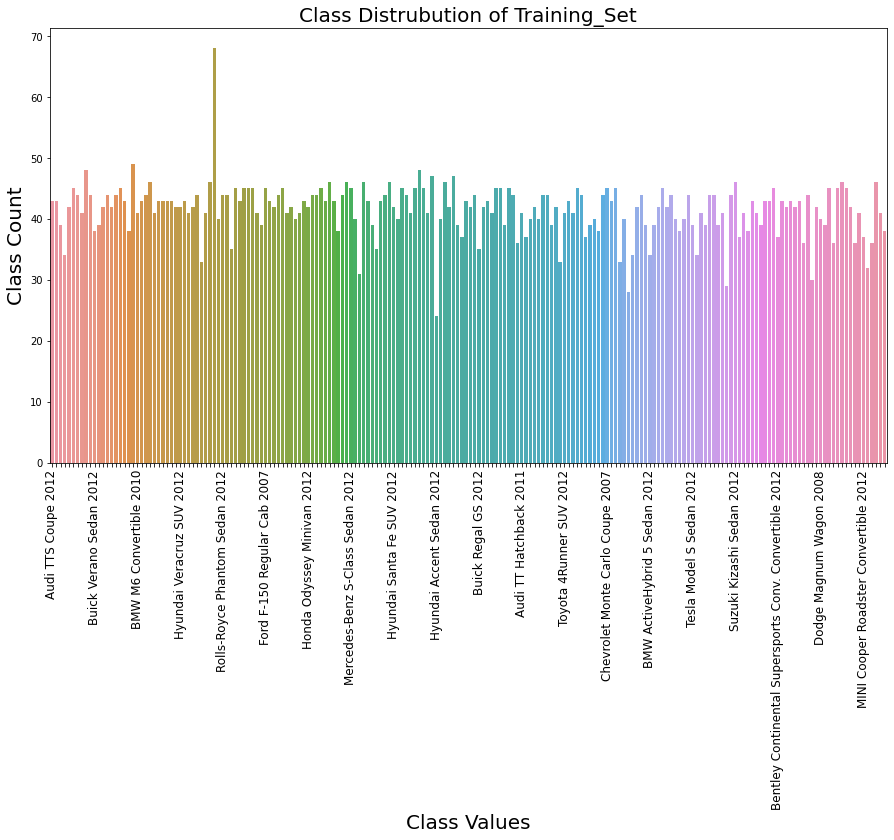

In [ ]:
# Class distribution of Training set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = train_df['class'])
plt.title('Class Distrubution of Training_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

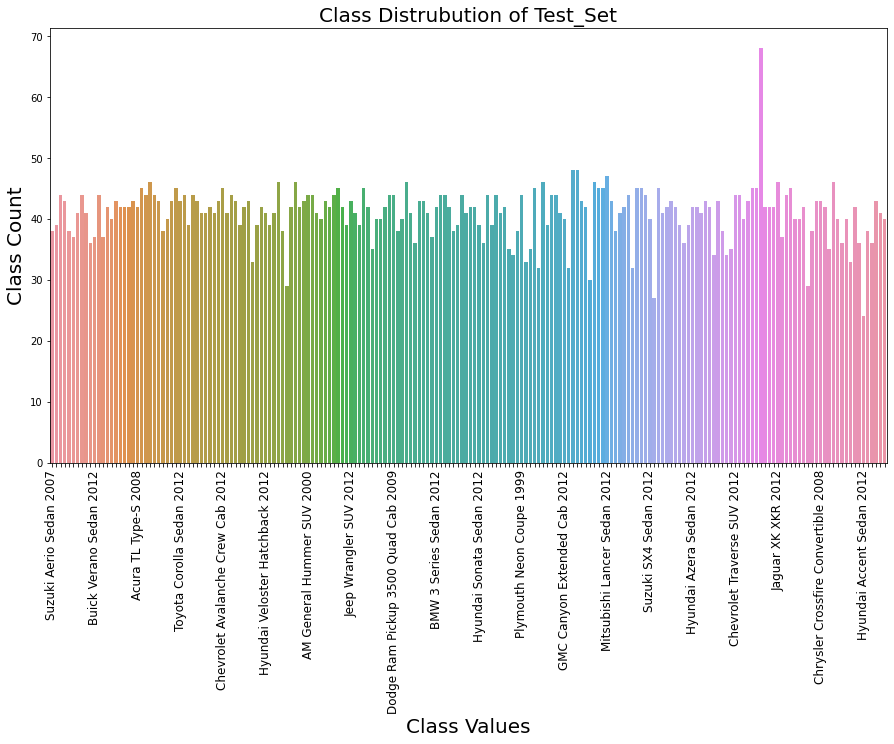

In [ ]:
# Class distribution of Test set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = test_df['class'])
plt.title('Class Distrubution of Test_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

## Visualize images

### Define Function: viz_images

In [ ]:
def viz_images(name, df, img_path, num_images, num_cols, col_size, row_size):

  '''
  Function to plot images along with labels from different sets

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    df: DataFrame from which information about image will be read
    img_path: Root path of images
    num_images: Number of images to plot
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = df.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    img_file = df.loc[value, 'filename']
    img = cv2.imread(os.path.join(img_path, img_file)) # Read the image
    xmin, ymin, xmax, ymax = df.loc[value, ['xmin', 'ymin', 'xmax', 'ymax']] # Get BBOX co-ords
    obj_class = df.loc[value, 'class'] # Get Class of object
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4) # Draw BBox in green color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.imshow(img)
    ax.set_title(obj_class, fontsize = 20)

  plt.show()

### Visualize images from training set

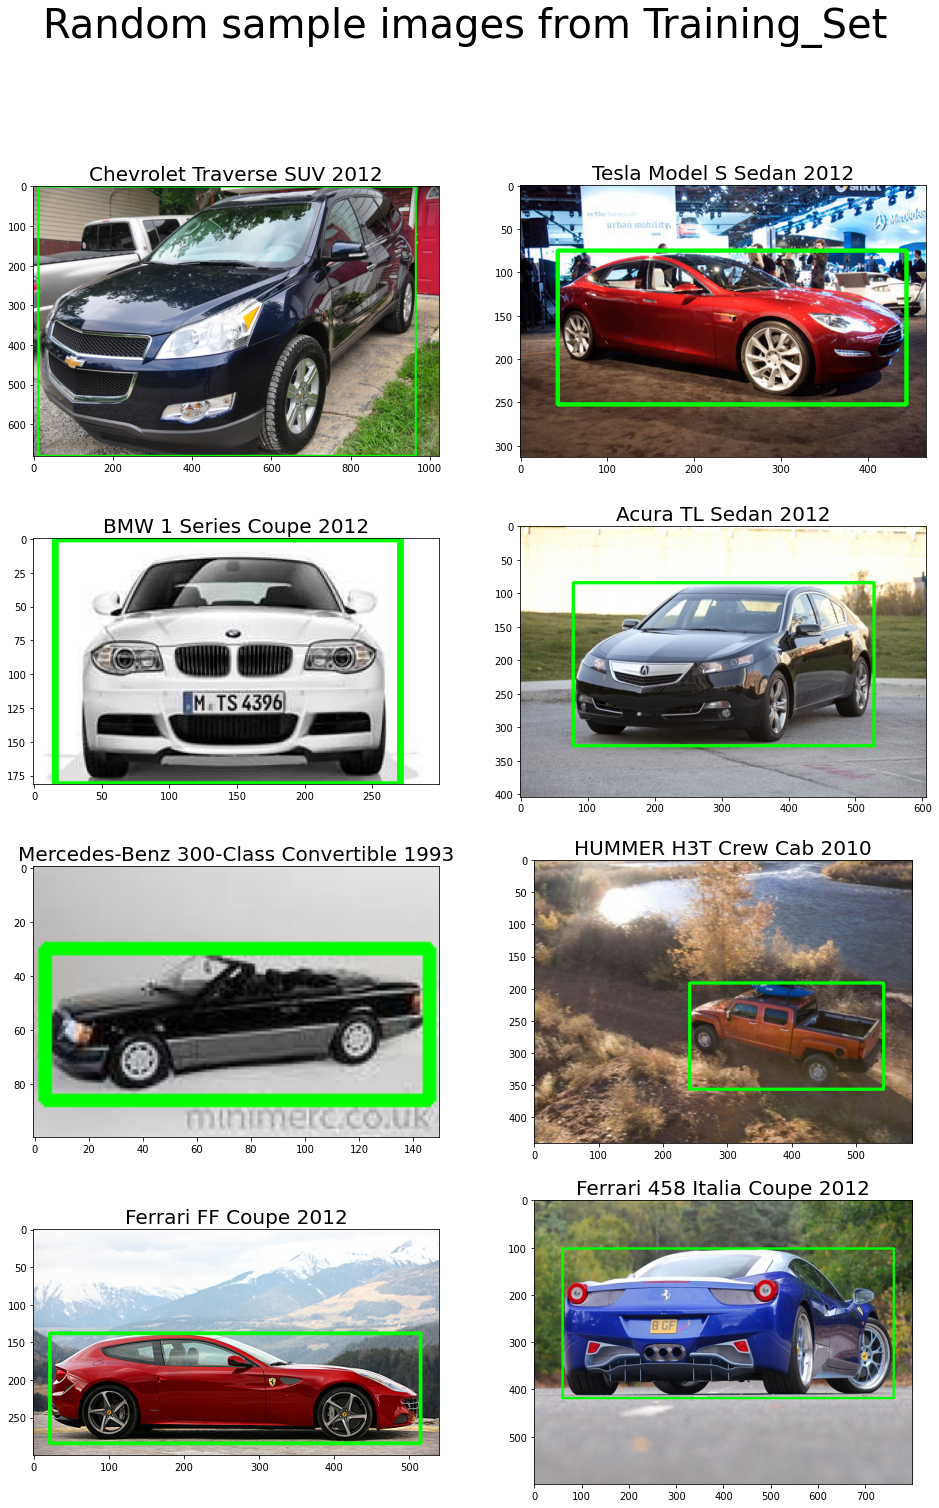

In [ ]:
viz_images('Training_Set', train_df, train_img_path, 8, 2, 8, 6)

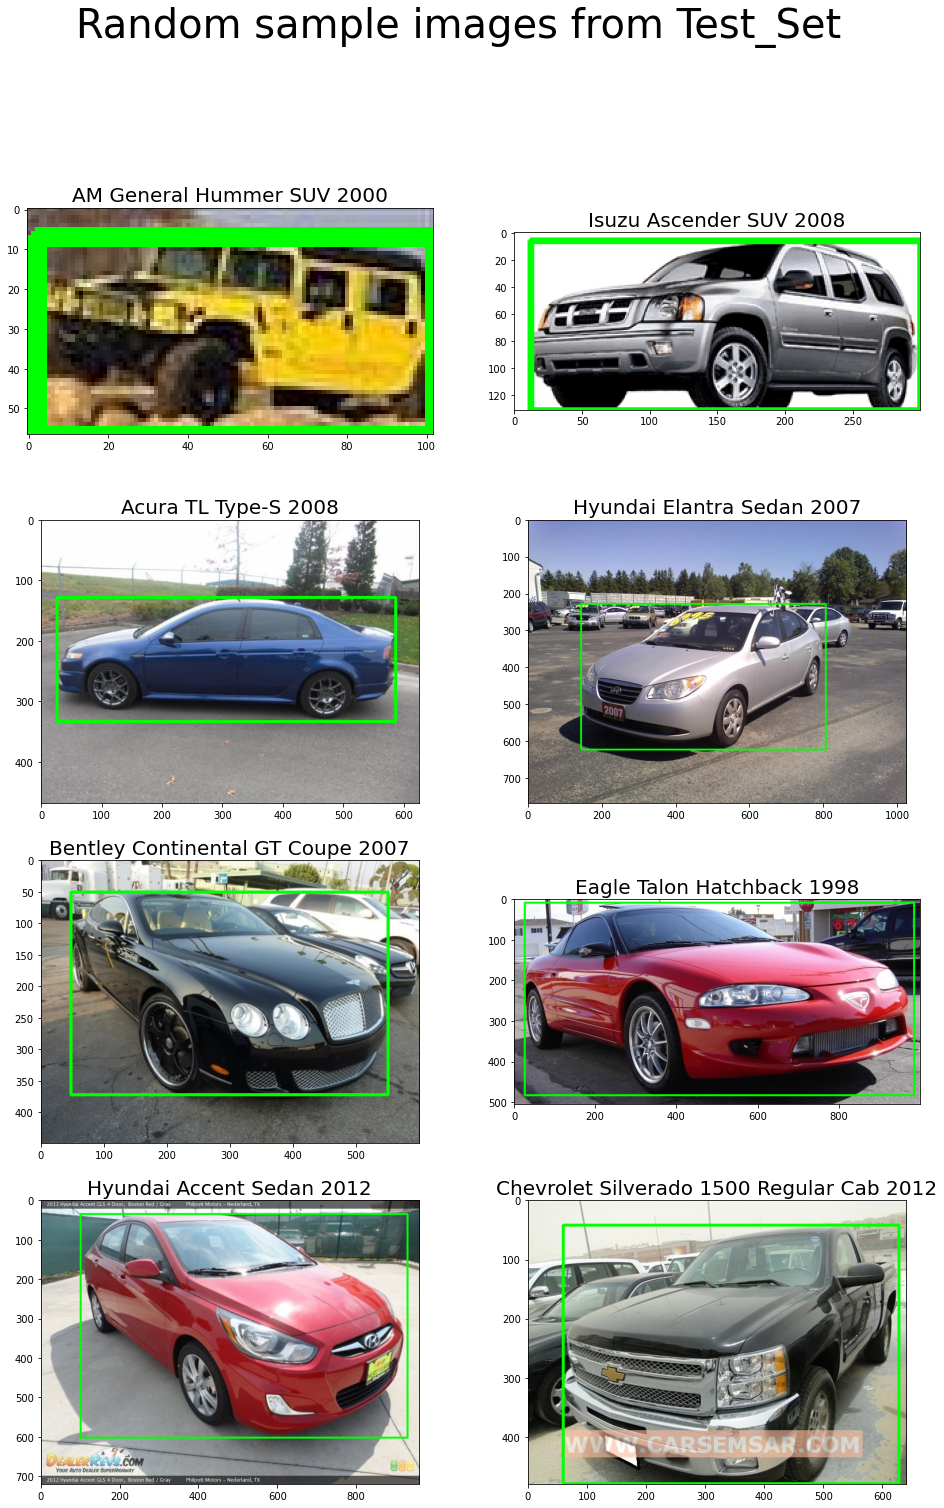

In [ ]:
viz_images('Test_Set', test_df, test_img_path, 8, 2, 8, 6)

# Complete setups required for training

## Save training and test dataframes as csv files

In [ ]:
train_df.to_csv('train.csv', index = False)
test_df.to_csv('test.csv', index = False)

## Generate tfrecord from CSV


In [ ]:
%%capture

#Generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv --img_path={train_img_path} --output_path=train.tfrecord
#Generate tfrecord for test data
!python generate_tfrecord.py --csv_input=test.csv --img_path={test_img_path} --output_path=test.tfrecord

## Download a pre-trained model

'SSD' with mobilnet base will be used for transfer learning.

In [ ]:
%%capture

# Download the model from zoo

!wget -q http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

# Extract tar file
!tar -xf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
# Delete tar file
!rm ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

## Prepare Training configuration file

A sample configuration for the chosen pre-trained model (ssd_mobilenet_v2_320x320_coco17_tpu-8) is copied from [Configs](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2) folder. The following updates have been made to 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config' file which is loaded from GitHub below:

1. 'num_classes' parameter set to 196 (as we have 196 classes of cars in this dataset).
2. For 'train_input_reader' 'input_path' set to 'train.tfrecord' (Location of train.tfrecord file).
3. For 'train_input_reader' 'label_map_path' set to 'label_map.txt' (path of label_map.txt file).
4. For 'eval_input_reader' 'input_path' set to 'test.tfrecord' (Location of test.tfrecord file).
5. For 'eval_input_reader' 'label_map_path' set to 'label_map.txt' (path of label_map.txt file).
5. 'fine_tune_checkpoint' set to "ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0"  (filepath of pre-trained model checkpoint file).
6. 'batch_size' set to 32. 
7. 'num_steps' set as per requirements of each run. 
8. 'use_matmul_crop_and_resize' set to False as it was causing memory issues.

## Load training configuration file

In [ ]:
%%capture

!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/TF_ObjDet_SSD_MobNet/ssd_mobilenet.config
config_file = 'ssd_mobilenet.config'

In [ ]:
!cat ssd_mobilenet.config

## Copy model training script

In [ ]:
# Copy training file from 'models/research/object_detection' folder to current folder
!cp /content/models/research/object_detection/model_main_tf2.py .

## Create training folder

In [ ]:
#!rm -rf training

In [ ]:
# Create a training folder to store model checkpoints/snapshots as training progresses
root_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model"
train_path = os.path.join(root_path, "Training_Files/")

In [ ]:
train_path

'/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Training_Files/'

## Launch Tensorboard

In [ ]:
#%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir {train_path}

# Train the model

## Start training

This section is commented out. The trained model is loaded from disk below.

In [ ]:
# Start training
# model_dir=training/ (path where outputs from model will be stored)
# pipeline_config_path={config_file} (config file that will be used for training and evaluation)
# checkpoint_every_n=100 (Checkpoint every 100 steps)
# !python model_main_tf2.py --model_dir={train_path} --pipeline_config_path={config_file} --checkpoint_every_n=1000 --alsologtostderr

## Evaluate Model on Test set

In [ ]:
# Start Evaluation
# Setting checkpoint_dir=training will set the model to eval-only mode.
# Results will be written to model_dir
# !python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr 

## Train and Evaluate in Background

If we want to evaluate our model on training data regularly, we have to run both training and evaluation script in parallel. Model evaluation on test data gets done everytime model checkpoint is saved during training.

### Clear existing logs

In [ ]:
# !rm train.txt
# !rm eval.txt

### Start train and eval

In [ ]:
# Start training
# !nohup /usr/bin/python3 model_main_tf2.py --model_dir={train_path} --pipeline_config_path={config_file} --checkpoint_every_n=1000 --alsologtostderr > train.txt 2>&1 &

In [ ]:
# Start evaluation
# !nohup /usr/bin/python3 model_main_tf2.py --model_dir={train_path} --pipeline_config_path={config_file} --checkpoint_dir={train_path} --alsologtostderr --sample_1_of_n_eval_examples=16 > eval.txt 2>&1 &

### Read output logs

In [ ]:
# !cat train.txt

In [ ]:
# !cat eval.txt

In [ ]:
# !ps

In [ ]:
# !kill -9 546
# !kill -9 556

# Export trained model

From the saved model checkpoints, we will create a frozen trained model. Frozen here means to remove model nodes which are no longer needed in prediction. This reduces model size.

In [ ]:
# Copy export_inference_graph.py file from models/research/object_detection to current directory
# !cp /content/models/research/object_detection/exporter_main_v2.py .

In [ ]:
# Provide input name, config file location, training folder
# input_type "image_tensor" => Input to model should be 4D tensor of shape [1, None, None, 3]
# Model will be created in output_directory. Directory will be created if it doesn't exist
# !python exporter_main_v2.py --input_type "image_tensor" --pipeline_config_path {config_file} --trained_checkpoint_dir {train_path} --output_directory detection_model

# Copy the trained model to Google Drive

## Save detection_model to drive

In [ ]:
# !cp -r detection_model '/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M3/'
# !rm -rf detection_model

## Save label class dictionary to drive

In [ ]:
# label_file_path = '/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M3/car_dataset_label.pkl'
# with open(label_file_path,'wb') as file:
#     pickle.dump(label_class_dict, file)

# Model Prediction

## Copy model and label class mapping from Google Drive

In [ ]:
# Copy model directory
!cp -r /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M3/detection_model .
# Copy label-class mapping pkl file
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M3/car_dataset_label.pkl .

## Extract label_class_dict from pkl file

In [ ]:
# Pickle file where index to label mapping is stored
fname = "/content/Dataset/car_dataset_label.pkl" 
with open(fname, "rb") as file:
    label_class_dict = pickle.load(file)
    
print(f"Type of label_class_dict is {type(label_class_dict)}")
print()
print(f"Keys of label_class_dict are:")
print("--------------------------------")
print(label_class_dict.keys())
print()
print("First five elements of label_class_dict are:")
print("-----------------------------------------------")
for ind in range(1, 6, 1):
    print(label_class_dict[ind])

Type of label_class_dict is <class 'dict'>

Keys of label_class_dict are:
--------------------------------
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196])

First fi

## Load Saved model

In [ ]:
%%capture
# Define path where model is stored
model_path = '/content/Dataset/detection_model/saved_model'
# Load model from path
model = tf.saved_model.load(model_path)

## Function: plt_img_w_bboxes

In [ ]:
def plt_img_w_bboxes(inp_img_path, score_threshold = 0.4, norm_coords = True, box_thickness = 3,\
                     font_size = 25):

    '''
    Take an input image path, extract the image, run inference on the image to get bounding boxes
    Plot bounding boxes and labels on top of the image
    '''
    
    inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
    inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
    inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
    model_out = model(inp_img_arr) # Pass input image through model
    
    scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
    boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
    class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
    
    # Draw box and labels on image
    inp_img_pil_w_bbox = draw_boxes_and_labels(inp_img_pil, scores, boxes, class_ind,\
                                               label_class_dict,\
                                               score_threshold = score_threshold,\
                                               norm_coords = norm_coords,\
                                               box_thickness = box_thickness, font_size = font_size)
    
    return inp_img_pil_w_bbox

In [ ]:
inp_img_path = "/content/Dataset/test_images/08037.jpg"
plt_img_w_bboxes(inp_img_path, score_threshold = 0.7)

In [ ]:
inp_img_path = "/content/Dataset/test_images/00003.jpg"
inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
model_out = model(inp_img_arr) # Pass input image through model

scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
print(scores[0:5])
print()
print([label_class_dict[ind] for ind in class_ind[0:5]])

In [ ]:
test_df

# Evaluate Performance

## Function: iou computation

In [ ]:
def iou(box1, box2):
    
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Extract x, y co-ordinates of both boxes
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (xi1, yi1, xi2, yi2) coordinates of the intersection of box1 and box2. 
    # Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max((xi2 - xi1),0)
    inter_height = max((yi2 - yi1),0)
    inter_area = inter_width * inter_height

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_y2 - box1_y1) * (box1_x2 - box1_x1)
    box2_area = (box2_y2 - box2_y1) * (box2_x2 - box2_x1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

## Function: model_eval

In [ ]:
def model_eval(df, img_root_path, num_samp):

  '''
  Function to evaluate the performance of the model given a certain set of images. 
  Classificaton accuracy and Mean IoU over all images will be computed and reported

  Arguments:
    df: Input Dataframe with image information
    img_root_path: Root path of images
    num_samp: Number of samples to use for evaluating model
  '''
  
  # Create a dataframe placeholder to store evaluation results
  df_cols = ['Act_Class', 'Pred_Class', 'Act_xmin', 'Act_ymin', 'Act_xmax', 'Act_ymax',\
           'Pred_xmin', 'Pred_ymin', 'Pred_xmax', 'Pred_ymax']
  results_df = pd.DataFrame(columns = df_cols) # Placeholder to store results
  corr_pred = 0 # counter to keep track of correct predictions
  iou_list = [] # List to store IoU values (of Actual BBOX vs. Predicted BBOX) for each image

  for samp_ind in tqdm(range(num_samp)): # Loop through num_samp
    img_file_name = df.loc[samp_ind, 'filename'] # Extract image filename from DataFrame
    img_file_path = os.path.join(img_root_path, img_file_name) # Obtain image file path
    img = cv2.cvtColor(cv2.imread(img_file_path), cv2.COLOR_BGR2RGB) # Load image
    img_mod = np.expand_dims(img, axis = 0) # Add batch axis to feed to model
    model_out = model(img_mod) # Pass input image through model 

    act_class = df.loc[samp_ind, 'class'] # Get ground-truth class
    label = model_out['detection_classes'][0].numpy().astype('int32')[0] # Extract class index
    pred_class = label_class_dict[label] # Obtain class prediction
    bbox = model_out['detection_boxes'][0].numpy()[0] # Extract BBOX co-ordinates
    img_h, img_w = df.loc[samp_ind, ['img_h', 'img_w']] # Extract image dimensions

    # Create entry_dict for updating dataframe
    entry_dict = {'Act_Class': act_class,
                  'Pred_Class': pred_class,
                  'Act_xmin': df.loc[samp_ind, 'xmin'],
                  'Act_ymin': df.loc[samp_ind, 'ymin'],
                  'Act_xmax': df.loc[samp_ind, 'xmax'],
                  'Act_ymax': df.loc[samp_ind, 'ymax'],
                  'Pred_xmin': int(bbox[1] * img_w),
                  'Pred_ymin': int(bbox[0] * img_h),
                  'Pred_xmax': int(bbox[3] * img_w),
                  'Pred_ymax': int(bbox[2] * img_h),
                }
    results_df = results_df.append(entry_dict, ignore_index = True) # Update dataframe

    # Update corr_pred
    corr_pred += int(entry_dict['Act_Class'] == entry_dict['Pred_Class'])

    # Compute IoU
    box1 = (entry_dict['Act_xmin'], entry_dict['Act_ymin'],\
            entry_dict['Act_xmax'], entry_dict['Act_ymax'])
    box2 = (entry_dict['Pred_xmin'], entry_dict['Pred_ymin'],\
            entry_dict['Pred_xmax'], entry_dict['Pred_ymax'])
    iou_list.append(iou(box1, box2))

  tot_pred = results_df.shape[0]
  print()
  print()
  print("Classification accuracy is %0.2f %%" %(100 * (corr_pred / tot_pred)))
  print("Mean IoU score is %0.4f" %(np.mean(iou_list)))

  return results_df, iou_list

## Evaluate model on training set

In [ ]:
train_img_root_path = "/content/Dataset/train_images"
train_results_df, train_iou_list = model_eval(train_df, train_img_root_path, 1000)

100%|██████████| 1000/1000 [01:45<00:00,  9.44it/s]



Classification accuracy is 99.40 %
Mean IoU score is 0.9438


## Evaluate model on test set

In [ ]:
test_img_root_path = "/content/Dataset/test_images"
test_results_df, test_iou_list = model_eval(test_df, test_img_root_path, 1000)

100%|██████████| 1000/1000 [01:45<00:00,  9.46it/s]



Classification accuracy is 67.80 %
Mean IoU score is 0.9177
